# KANs Example Revisited

Source: https://github.com/KindXiaoming/pykan/blob/master/tutorials/Example_2_deep_formula.ipynb

## "With a bit noise in training dataset, it becomes a totally different story!"

In [1]:
pip install pykan

In [2]:
def create_dataset2(f,
                   n_var=2,
                   ranges = [-1,1],
                   train_num=1000,
                   test_num=1000,
                   normalize_input=True,
                   normalize_label=True,
                   add_noise=True,  # add noise
                   noise_level=0.1,
                   device='cpu',
                   seed=0):
    '''
    create dataset

    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input variables. Default: [-1,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.

    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']

    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var,2)
    else:
        ranges = np.array(ranges)

    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:,i] = torch.rand(train_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        test_input[:,i] = torch.rand(test_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]


    train_label = f(train_input)
    test_label = f(test_input)


    def normalize(data, mean, std):
            return (data-mean)/std

    if normalize_input == True:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)

    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    if add_noise:
        noise = torch.randn_like(test_label) * noise_level
        test_label += noise

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)

    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset


In [3]:
from kan import KAN, create_dataset
import torch
import numpy as np


# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,2,1,1], grid=3, k=3, seed=0)
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset2(f, n_var=4, train_num=1000, test_num=1000, noise_level=0.1)

image_folder = 'video_img'

# train the model
#model.train(dataset, opt="LBFGS", steps=20, lamb=1e-3, lamb_entropy=2.);
model.train(dataset, opt="LBFGS", steps=50, lamb=5e-5, lamb_entropy=2., save_fig=True, beta=10,
            in_vars=[r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$'],
            out_vars=[r'${\rm exp}({\rm sin}(x_1^2+x_2^2)+{\rm sin}(x_3^2+x_4^2))$'],
            img_folder=image_folder);

train loss: 1.09e-02 | test loss: 1.01e-01 | reg: 1.04e+01 : 100%|██| 50/50 [03:20<00:00,  4.02s/it]


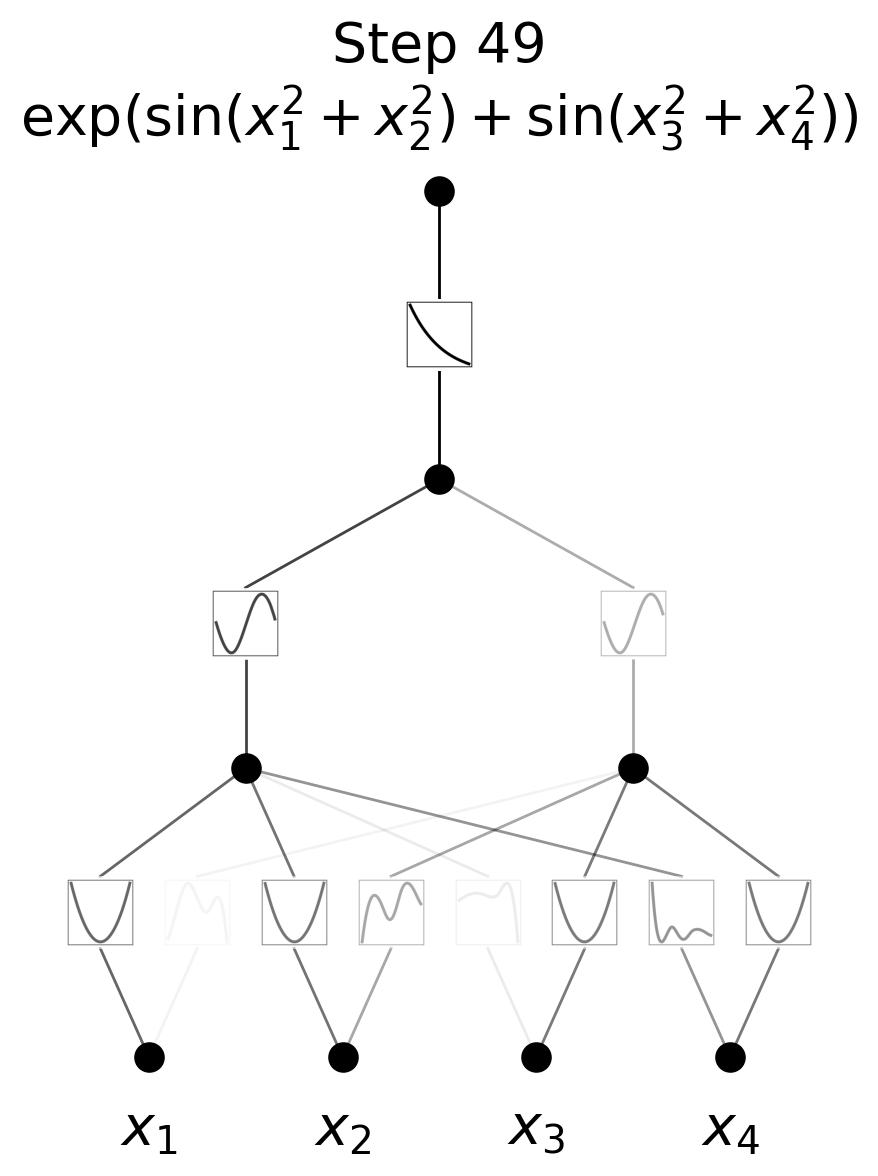

In [4]:
from IPython.display import Image

Image(filename='/content/video_img/49.jpg', height=600)

In [ ]:
import os
import numpy as np
import moviepy.video.io.ImageSequenceClip # moviepy == 1.0.3

video_name='video'
fps=5

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4
